# Tutorial 4: Spatial and Advanced Connectivity Patterns

In this tutorial, we explore advanced connectivity patterns that incorporate spatial organization and complex topological structures. These patterns are essential for modeling realistic neural networks where physical location and network structure significantly influence connectivity.

**Learning Objectives:**
- Understand distance-dependent connectivity patterns
- Master topological network structures (small-world, scale-free, modular)
- Learn to combine multiple connectivity strategies
- Apply constraints to connectivity patterns
- Build multi-scale networks

**Prerequisites:**
- Tutorial 1: Basic Connectivity Patterns
- Tutorial 2: Model-Specific Connectivity
- Tutorial 3: Composable Weight and Delay Initialization

In [1]:
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import braintools.conn as conn
import braintools.visualize as vis

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

## 1. Distance-Dependent Connectivity

Distance-dependent connectivity is fundamental in neuroscience, as connection probability and strength typically decrease with spatial distance between neurons.

### 1.1 Gaussian Distance Profile

Gaussian profiles model local connectivity with smooth decay:

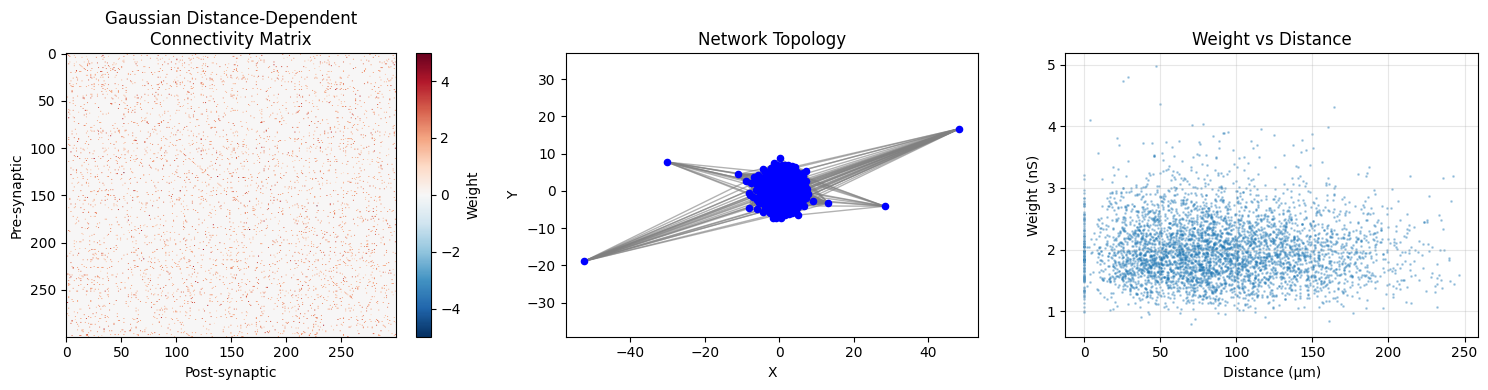

In [2]:
n_neurons = 300
positions = np.random.uniform(0, 500, (n_neurons, 2)) * u.um

gaussian_conn = conn.DistanceDependent(
    distance_profile=conn.GaussianProfile(
        sigma=80 * u.um,
        max_distance=250 * u.um
    ),
    weight=conn.LogNormalWeight(mean=2.0 * u.nS, std=0.5 * u.nS),
    delay=conn.UniformDelay(low=0.8 * u.ms, high=2.0 * u.ms),
    max_prob=0.4
)

result = gaussian_conn(
    pre_size=n_neurons,
    post_size=n_neurons,
    pre_positions=positions,
    post_positions=positions
)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
vis.connectivity_matrix(
    u.get_magnitude(result.weight2dense()),
    ax=axes[0],
    title='Gaussian Distance-Dependent\nConnectivity Matrix'
)
vis.network_topology(
    u.get_magnitude(result.weight2dense()),
    ax=axes[1],
    title='Network Topology',
    node_sizes=20
)

from scipy.spatial.distance import cdist

pre_pos = positions.to(u.um).mantissa
distances = cdist(pre_pos[result.pre_indices], pre_pos[result.post_indices])
distances = distances[np.arange(len(distances)), np.arange(len(distances))]

axes[2].scatter(distances, result.weights.to(u.nS).mantissa, alpha=0.3, s=1)
axes[2].set_xlabel('Distance (μm)')
axes[2].set_ylabel('Weight (nS)')
axes[2].set_title('Weight vs Distance')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.2 Exponential Distance Profile

Exponential decay is common for long-range connections:

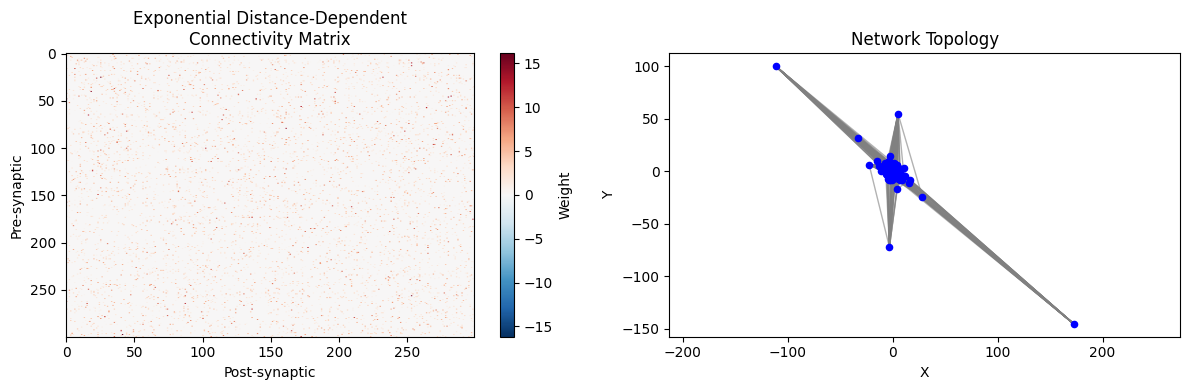

In [3]:
exponential_conn = conn.DistanceDependent(
    distance_profile=conn.ExponentialProfile(
        decay_constant=120 * u.um,
        max_distance=400 * u.um
    ),
    weight=conn.GammaWeight(shape=2.0, scale=1.5 * u.nS),
    delay=conn.NormalDelay(mean=1.5 * u.ms, std=0.4 * u.ms),
    max_prob=0.35
)

result_exp = exponential_conn(
    pre_size=n_neurons,
    post_size=n_neurons,
    pre_positions=positions,
    post_positions=positions
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
vis.connectivity_matrix(
    u.get_magnitude(result_exp.weight2dense()),
    ax=axes[0],
    title='Exponential Distance-Dependent\nConnectivity Matrix'
)
vis.network_topology(
    u.get_magnitude(result_exp.weight2dense()),
    ax=axes[1],
    title='Network Topology',
    node_sizes=20
)
plt.tight_layout()
plt.show()

### 1.3 Comparing Distance Profiles

Let's compare different distance profiles side by side:

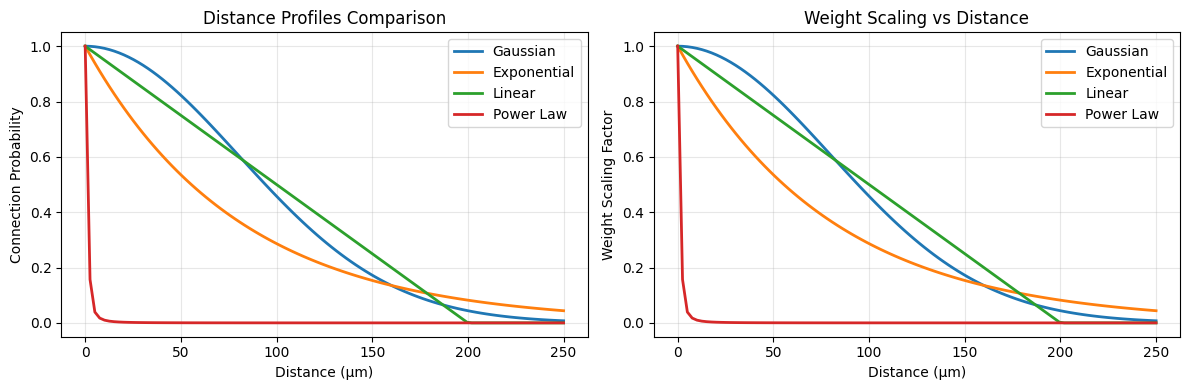

In [4]:
profiles = [
    ('Gaussian', conn.GaussianProfile(sigma=80 * u.um)),
    ('Exponential', conn.ExponentialProfile(decay_constant=80 * u.um)),
    ('Linear', conn.LinearProfile(max_distance=200 * u.um)),
    ('Power Law', conn.PowerLawProfile(exponent=2.0, min_distance=1 * u.um))
]

distances_test = np.linspace(0, 250, 100) * u.um

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for name, profile in profiles:
    probs = profile.probability(distances_test)
    axes[0].plot(distances_test.to(u.um).mantissa, probs, label=name, linewidth=2)

axes[0].set_xlabel('Distance (μm)')
axes[0].set_ylabel('Connection Probability')
axes[0].set_title('Distance Profiles Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for name, profile in profiles:
    weights_scaling = profile.weight_scaling(distances_test)
    axes[1].plot(distances_test.to(u.um).mantissa, weights_scaling, label=name, linewidth=2)

axes[1].set_xlabel('Distance (μm)')
axes[1].set_ylabel('Weight Scaling Factor')
axes[1].set_title('Weight Scaling vs Distance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Topological Network Patterns

Topological patterns define the global structure of connectivity independent of spatial distance.

### 2.1 Small-World Networks

Small-world networks (Watts-Strogatz) combine high clustering with short path lengths:

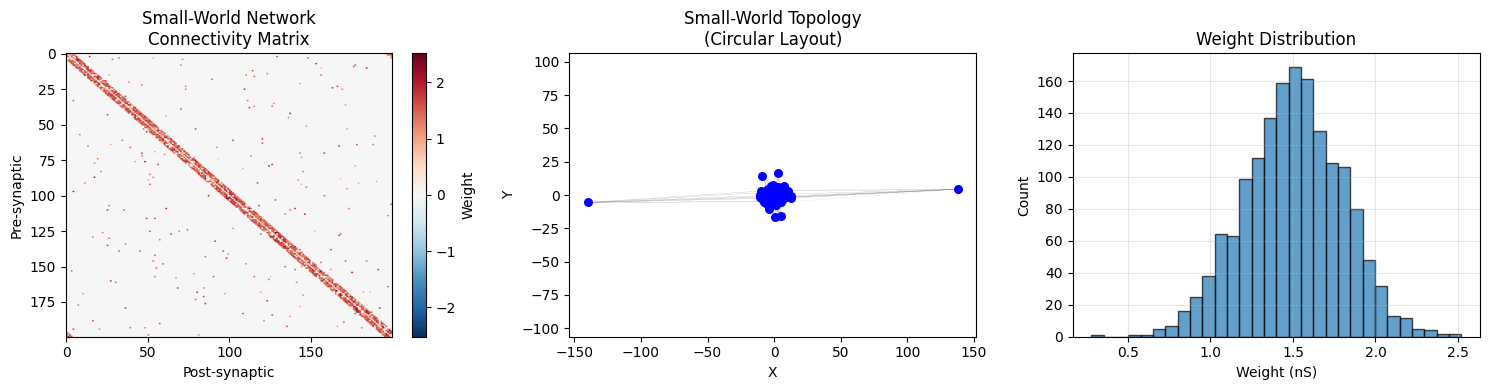

In [5]:
n_neurons = 200

small_world = conn.SmallWorld(
    k=8,
    p=0.15,
    weight=conn.NormalWeight(mean=1.5 * u.nS, std=0.3 * u.nS),
    delay=conn.GammaDelay(shape=2.0, scale=0.8 * u.ms)
)

result_sw = small_world(pre_size=n_neurons, post_size=n_neurons)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vis.connectivity_matrix(
    u.get_magnitude(result_sw.weight2dense()),
    ax=axes[0],
    title='Small-World Network\nConnectivity Matrix'
)

circular_positions = np.zeros((n_neurons, 2))
angles = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)
circular_positions[:, 0] = 100 * np.cos(angles)
circular_positions[:, 1] = 100 * np.sin(angles)
result_sw_vis = result_sw
result_sw_vis.pre_positions = circular_positions * u.um
result_sw_vis.post_positions = circular_positions * u.um

vis.network_topology(
    u.get_magnitude(result_sw_vis.weight2dense()),
    ax=axes[1],
    title='Small-World Topology\n(Circular Layout)',
    node_sizes=30,
    edge_widths=0.1
)

axes[2].hist(result_sw.weights.to(u.nS).mantissa, bins=30, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Weight (nS)')
axes[2].set_ylabel('Count')
axes[2].set_title('Weight Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Scale-Free Networks

Scale-free networks (Barabási-Albert) exhibit hub-like structures with power-law degree distributions:

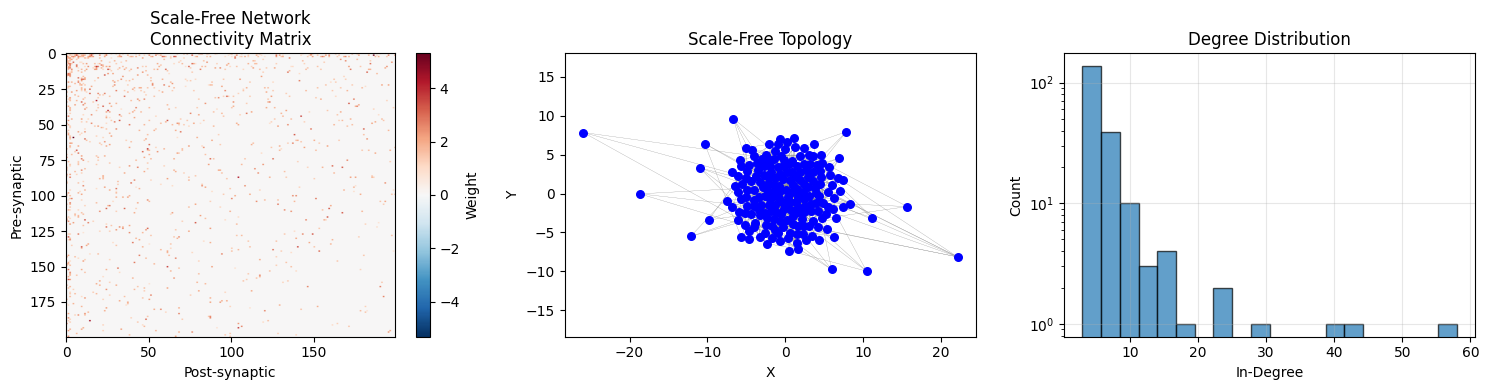

In [6]:
scale_free = conn.ScaleFree(
    m=3,
    weight=conn.LogNormalWeight(mean=1.8 * u.nS, std=0.6 * u.nS),
    delay=conn.UniformDelay(low=0.5 * u.ms, high=2.5 * u.ms)
)

result_sf = scale_free(pre_size=n_neurons, post_size=n_neurons)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vis.connectivity_matrix(
    u.get_magnitude(result_sf.weight2dense()),
    ax=axes[0],
    title='Scale-Free Network\nConnectivity Matrix'
)

random_positions = np.random.uniform(-100, 100, (n_neurons, 2)) * u.um
result_sf._pre_positions = random_positions
result_sf._post_positions = random_positions
vis.network_topology(
    u.get_magnitude(result_sf.weight2dense()),
    ax=axes[1],
    title='Scale-Free Topology',
    node_sizes=30,
    edge_widths=0.15
)

in_degrees = np.bincount(result_sf.post_indices, minlength=n_neurons)
axes[2].hist(in_degrees, bins=20, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('In-Degree')
axes[2].set_ylabel('Count')
axes[2].set_title('Degree Distribution')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Modular Networks

Modular networks have strong within-module connectivity and weak between-module connections:

In [7]:
module_sizes = [60, 50, 70]
total_neurons = sum(module_sizes)

within_module = conn.Random(
    prob=0.25,
    weight=conn.NormalWeight(mean=2.5 * u.nS, std=0.5 * u.nS),
    delay=conn.ConstantDelay(1.0 * u.ms)
)

between_module = conn.Random(
    prob=0.05,
    weight=conn.NormalWeight(mean=0.8 * u.nS, std=0.2 * u.nS),
    delay=conn.UniformDelay(low=2.0 * u.ms, high=4.0 * u.ms)
)

# modular = conn.Modular(
#     module_sizes=module_sizes,
#     within_module_conn=within_module,
#     between_module_conn=between_module
# )
#
# result_mod = modular(pre_size=total_neurons, post_size=total_neurons)
#
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#
# vis.connectivity_matrix(
#     u.get_magnitude(result_mod.weight2dense()),
#     ax=axes[0],
#     title='Modular Network\nConnectivity Matrix'
# )
#
# module_positions = []
# centers = [(0, 0), (150, 100), (-100, -120)]
# for i, (size, center) in enumerate(zip(module_sizes, centers)):
#     angles = np.random.uniform(0, 2 * np.pi, size)
#     radii = np.random.uniform(0, 40, size)
#     x = center[0] + radii * np.cos(angles)
#     y = center[1] + radii * np.sin(angles)
#     module_positions.append(np.column_stack([x, y]))
#
# all_positions = np.vstack(module_positions) * u.um
# result_mod._pre_positions = all_positions
# result_mod._post_positions = all_positions
#
# vis.network_topology(
#     u.get_magnitude(result_mod.weight2dense()),
#     ax=axes[1],
#     title='Modular Topology',
#     node_sizes=25,
#     edge_widths=0.08
# )
#
# axes[2].hist(result_mod.weights.to(u.nS).mantissa, bins=40, alpha=0.7, edgecolor='black')
# axes[2].set_xlabel('Weight (nS)')
# axes[2].set_ylabel('Count')
# axes[2].set_title('Weight Distribution\n(Bimodal: Within vs Between)')
# axes[2].grid(True, alpha=0.3)
#
# plt.tight_layout()
plt.show()

## 3. Combining Connectivity Patterns

Real neural networks often combine multiple connectivity principles. We can use composition to create hybrid patterns.

### 3.1 Multi-Scale Spatial Network

Combine local and long-range connectivity:

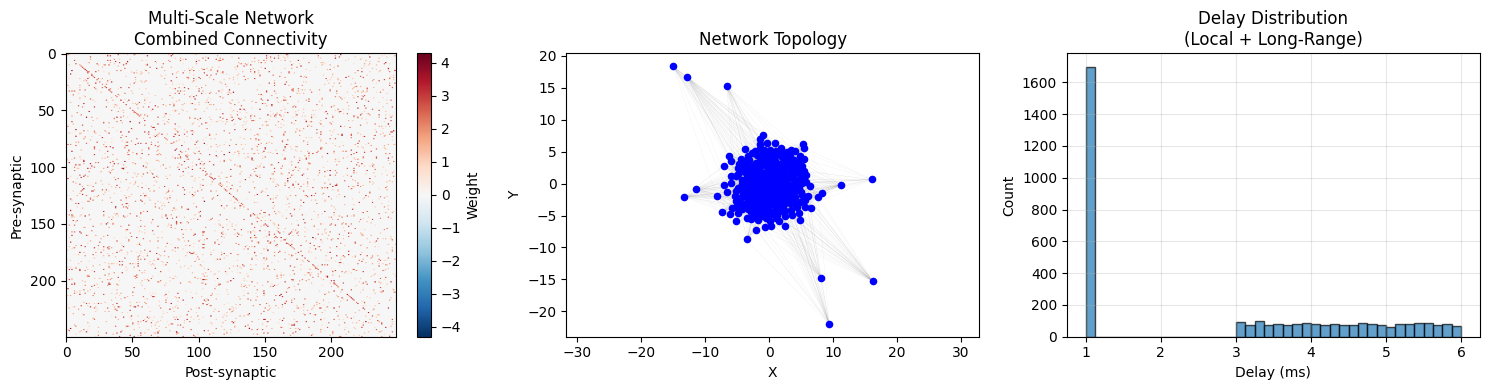

In [8]:
n_neurons = 250
positions = np.random.uniform(0, 500, (n_neurons, 2)) * u.um

local_conn = conn.DistanceDependent(
    distance_profile=conn.GaussianProfile(sigma=50 * u.um, max_distance=150 * u.um),
    weight=conn.NormalWeight(mean=2.5 * u.nS, std=0.5 * u.nS),
    delay=conn.ConstantDelay(1.0 * u.ms),
    max_prob=0.5
)

long_range_conn = conn.Random(
    prob=0.03,
    weight=conn.NormalWeight(mean=1.2 * u.nS, std=0.3 * u.nS),
    delay=conn.UniformDelay(low=3.0 * u.ms, high=6.0 * u.ms)
)

result_local = local_conn(
    pre_size=n_neurons,
    post_size=n_neurons,
    pre_positions=positions,
    post_positions=positions
)

result_long = long_range_conn(pre_size=n_neurons, post_size=n_neurons)

combined_pre = np.concatenate([result_local.pre_indices, result_long.pre_indices])
combined_post = np.concatenate([result_local.post_indices, result_long.post_indices])
combined_weights = np.concatenate([result_local.weights.mantissa, result_long.weights.mantissa]) * u.nS
combined_delays = np.concatenate([result_local.delays.mantissa, result_long.delays.mantissa]) * u.ms

result_combined = conn.ConnectionResult(
    combined_pre,
    combined_post,
    pre_size=n_neurons,
    post_size=n_neurons,
    weights=combined_weights,
    delays=combined_delays,
    pre_positions=positions,
    post_positions=positions,
    model_type='point'
)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vis.connectivity_matrix(
    u.get_magnitude(result_combined.weight2dense()),
    ax=axes[0],
    title='Multi-Scale Network\nCombined Connectivity'
)
vis.network_topology(
    u.get_magnitude(result_combined.weight2dense()),
    ax=axes[1],
    title='Network Topology',
    node_sizes=20,
    edge_widths=0.05
)

axes[2].hist(result_combined.delays.to(u.ms).mantissa, bins=40, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Delay (ms)')
axes[2].set_ylabel('Count')
axes[2].set_title('Delay Distribution\n(Local + Long-Range)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Spatial Small-World Network

Combine spatial organization with small-world topology:

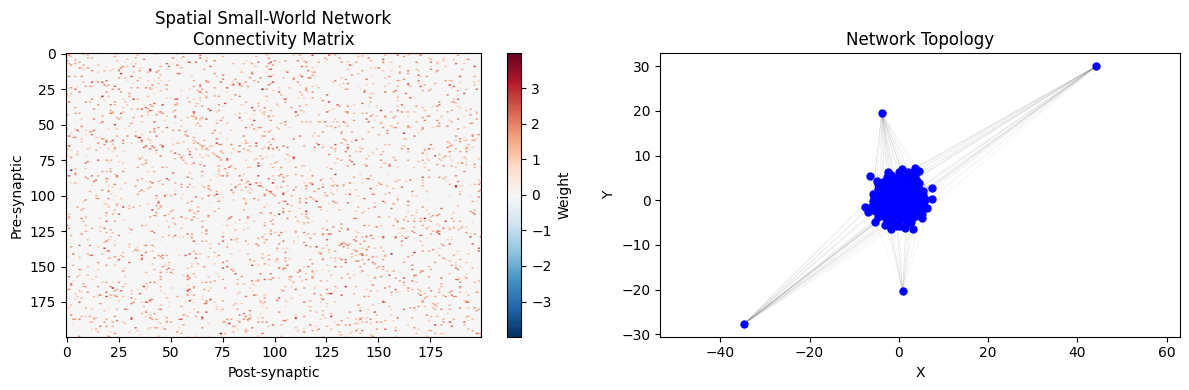

In [9]:
n_neurons = 200
positions = np.random.uniform(0, 400, (n_neurons, 2)) * u.um

spatial_base = conn.DistanceDependent(
    distance_profile=conn.ExponentialProfile(decay_constant=80 * u.um),
    weight=conn.LogNormalWeight(mean=1.8 * u.nS, std=0.5 * u.nS),
    delay=conn.DistanceProportionalDelay(
        base_delay=0.5 * u.ms,
        velocity=300 * u.um / u.ms,
        max_delay=5.0 * u.ms
    ),
    max_prob=0.3
)

rewired_shortcuts = conn.Random(
    prob=0.02,
    weight=conn.NormalWeight(mean=1.0 * u.nS, std=0.2 * u.nS),
    delay=conn.UniformDelay(low=2.0 * u.ms, high=4.0 * u.ms)
)

result_spatial_sw = (spatial_base + rewired_shortcuts)(
    pre_size=n_neurons,
    post_size=n_neurons,
    pre_positions=positions,
    post_positions=positions
)

result_shortcuts = rewired_shortcuts(pre_size=n_neurons, post_size=n_neurons)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

vis.connectivity_matrix(
    u.get_magnitude(result_spatial_sw.weight2dense()),
    ax=axes[0],
    title='Spatial Small-World Network\nConnectivity Matrix'
)
vis.network_topology(
    u.get_magnitude(result_spatial_sw.weight2dense()),
    ax=axes[1],
    title='Network Topology',
    node_sizes=25,
    edge_widths=0.08
)

plt.tight_layout()
plt.show()

## 4. Advanced Constraint Application

Constraints allow fine-tuning of connectivity patterns to match biological observations.

### 4.1 Regular Grid Connectivity

Grid patterns are useful for modeling structured topologies:

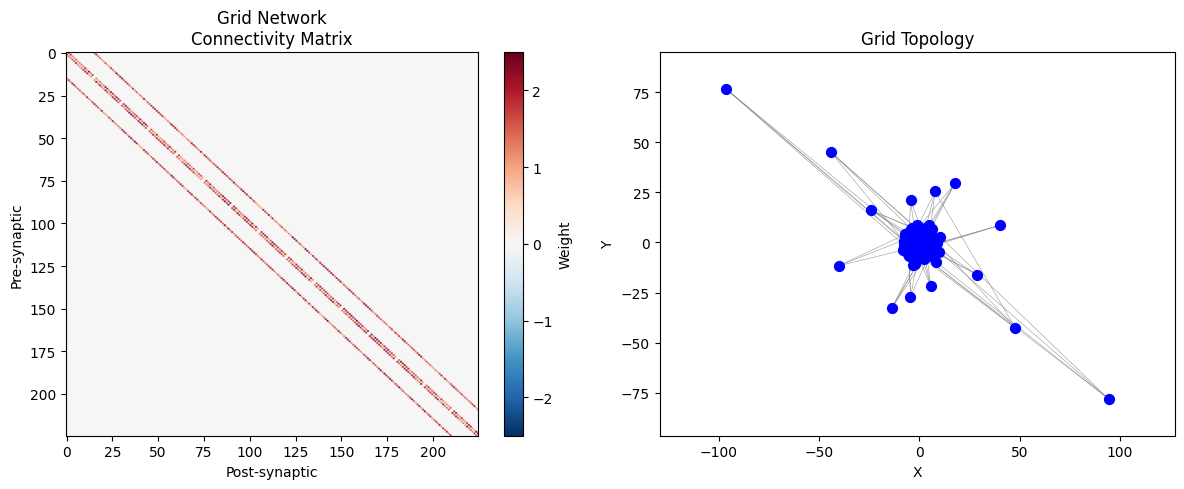

In [10]:
grid_size = 15
n_grid = grid_size * grid_size

x = np.repeat(np.arange(grid_size), grid_size)
y = np.tile(np.arange(grid_size), grid_size)
grid_positions = np.column_stack([x, y]) * 30 * u.um

grid_conn = conn.Grid(
    grid_shape=(15, 15),
    weight=conn.UniformWeight(low=1.0 * u.nS, high=2.5 * u.nS),
    delay=conn.ConstantDelay(1.2 * u.ms)
)

result_grid = grid_conn(
    pre_size=(grid_size, grid_size),
    post_size=(grid_size, grid_size)
)

result_grid._pre_positions = grid_positions
result_grid._post_positions = grid_positions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

vis.connectivity_matrix(
    u.get_magnitude(result_grid.weight2dense()),
    ax=axes[0],
    title='Grid Network\nConnectivity Matrix'
)
vis.network_topology(
    u.get_magnitude(result_grid.weight2dense()),
    ax=axes[1],
    title='Grid Topology',
    node_sizes=50,
    edge_widths=0.3
)

plt.tight_layout()
plt.show()

### 4.2 Ring Connectivity

Ring patterns model cyclic connectivity:

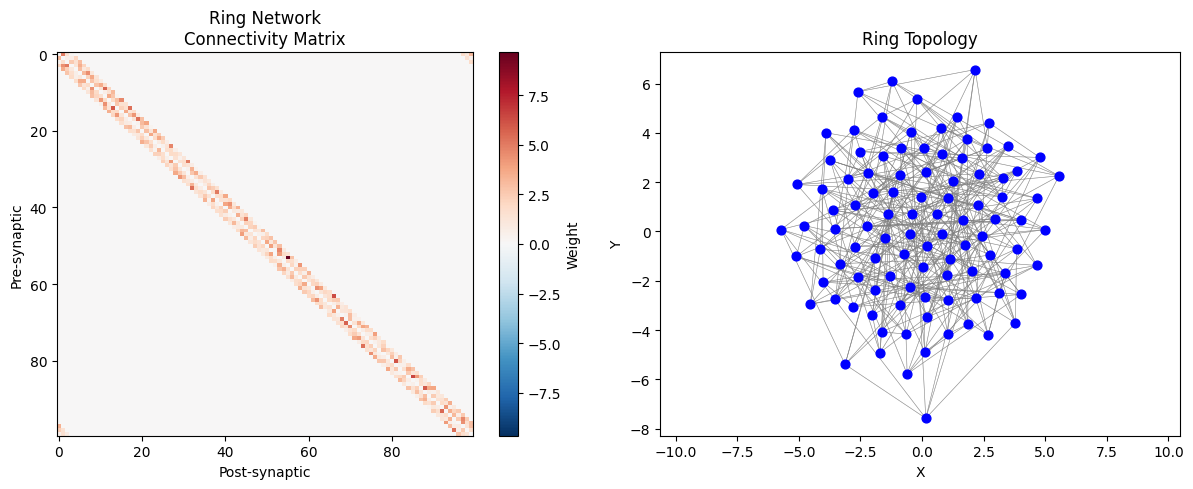

In [11]:
n_ring = 100

ring_conn = conn.Ring(
    neighbors=3,
    bidirectional=True,
    weight=conn.GammaWeight(shape=2.5, scale=0.8 * u.nS),
    delay=conn.NormalDelay(mean=1.5 * u.ms, std=0.3 * u.ms)
)

result_ring = ring_conn(pre_size=n_ring, post_size=n_ring)

angles = np.linspace(0, 2 * np.pi, n_ring, endpoint=False)
ring_positions = np.column_stack([100 * np.cos(angles), 100 * np.sin(angles)]) * u.um
result_ring._pre_positions = ring_positions
result_ring._post_positions = ring_positions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

vis.connectivity_matrix(
    u.get_magnitude(result_ring.weight2dense()),
    ax=axes[0],
    title='Ring Network\nConnectivity Matrix'
)
vis.network_topology(
    u.get_magnitude(result_ring.weight2dense()),
    ax=axes[1],
    title='Ring Topology',
    node_sizes=40,
    edge_widths=0.4
)

plt.tight_layout()
plt.show()

## 5. Example Project: Realistic Cortical Microcircuit

Let's build a comprehensive cortical microcircuit combining multiple connectivity principles:

- **Spatial organization**: Gaussian distance-dependent connectivity
- **E-I balance**: 80% excitatory, 20% inhibitory neurons
- **Small-world shortcuts**: Long-range excitatory connections
- **Modular structure**: 3 interconnected modules
- **Realistic parameters**: Log-normal weights, distance-proportional delays
- **Biological constraints**: Dale's principle, degree limits

In [12]:
print("Building realistic cortical microcircuit...\n")

n_exc = 320
n_inh = 80
n_total = n_exc + n_inh

module1_size = 120
module2_size = 140
module3_size = 140

positions = np.zeros((n_total, 2))
positions[:module1_size] = np.random.randn(module1_size, 2) * 80 + np.array([0, 0])
positions[module1_size:module1_size + module2_size] = np.random.randn(module2_size, 2) * 80 + np.array([300, 150])
positions[module1_size + module2_size:] = np.random.randn(module3_size, 2) * 80 + np.array([-200, 200])
positions = positions * u.um

exc_indices = np.arange(n_exc)
inh_indices = np.arange(n_exc, n_total)

print("Network Configuration:")
print(f"  Total neurons: {n_total}")
print(f"  Excitatory: {n_exc} (80%)")
print(f"  Inhibitory: {n_inh} (20%)")
print(f"  Modules: {module1_size}, {module2_size}, {module3_size}\n")

print("Generating connectivity...")

exc_to_exc = conn.DistanceDependent(
    distance_profile=conn.GaussianProfile(
        sigma=100 * u.um,
        max_distance=350 * u.um
    ),
    weight=conn.DistanceModulatedWeight(
        base_dist=conn.LogNormalWeight(mean=1.8 * u.nS, std=0.6 * u.nS),
        distance_profile='exponential',
        sigma=120 * u.um
    ),
    delay=conn.DistanceProportionalDelay(
        base_delay=0.5 * u.ms,
        velocity=300 * u.um / u.ms,
        max_delay=4.0 * u.ms
    ),
    max_prob=0.15
)

result_ee = exc_to_exc(
    pre_size=n_exc,
    post_size=n_exc,
    pre_positions=positions[:n_exc],
    post_positions=positions[:n_exc]
)

exc_to_inh = conn.DistanceDependent(
    distance_profile=conn.ExponentialProfile(decay_constant=80 * u.um, max_distance=250 * u.um),
    weight=conn.GammaWeight(shape=3.0, scale=0.8 * u.nS),
    delay=conn.UniformDelay(low=0.8 * u.ms, high=1.5 * u.ms),
    max_prob=0.25
)

result_ei = exc_to_inh(
    pre_size=n_exc,
    post_size=n_inh,
    pre_positions=positions[:n_exc],
    post_positions=positions[n_exc:]
)

inh_to_exc = conn.DistanceDependent(
    distance_profile=conn.GaussianProfile(
        sigma=70 * u.um,
        max_distance=200 * u.um
    ),
    weight=conn.DistanceModulatedWeight(
        base_dist=conn.LogNormalWeight(mean=-1.2 * u.nS, std=0.5 * u.nS),
        distance_profile='gaussian',
        sigma=90 * u.um
    ),
    delay=conn.DistanceProportionalDelay(
        base_delay=0.3 * u.ms,
        velocity=400 * u.um / u.ms,
        max_delay=2.5 * u.ms
    ),
    max_prob=0.35
)

result_ie = inh_to_exc(
    pre_size=n_inh,
    post_size=n_exc,
    pre_positions=positions[n_exc:],
    post_positions=positions[:n_exc]
)

inh_to_inh = conn.Random(
    prob=0.15,
    weight=conn.NormalWeight(mean=-0.8 * u.nS, std=0.2 * u.nS),
    delay=conn.ConstantDelay(0.8 * u.ms)
)

result_ii = inh_to_inh(pre_size=n_inh, post_size=n_inh)

long_range_exc = conn.Random(
    prob=0.02,
    weight=conn.LogNormalWeight(mean=1.0 * u.nS, std=0.4 * u.nS),
    delay=conn.UniformDelay(low=4.0 * u.ms, high=8.0 * u.ms)
)

result_long = long_range_exc(pre_size=n_exc, post_size=n_exc)

print("\nConnection Statistics:")
print(f"  E→E: {result_ee.n_connections} connections")
print(f"  E→I: {result_ei.n_connections} connections")
print(f"  I→E: {result_ie.n_connections} connections")
print(f"  I→I: {result_ii.n_connections} connections")
print(f"  Long-range E→E: {result_long.n_connections} connections")

total_connections = (result_ee.n_connections +
                     result_ei.n_connections +
                     result_ie.n_connections +
                     result_ii.n_connections +
                     result_long.n_connections)
print(f"  Total: {total_connections} connections")

all_pre = np.concatenate([
    result_ee.pre_indices,
    result_ei.pre_indices,
    result_ie.pre_indices + n_exc,
    result_ii.pre_indices + n_exc,
    result_long.pre_indices
])
all_post = np.concatenate([
    result_ee.post_indices,
    result_ei.post_indices + n_exc,
    result_ie.post_indices,
    result_ii.post_indices + n_exc,
    result_long.post_indices
])
all_weights = np.concatenate([
    result_ee.weights.mantissa,
    result_ei.weights.mantissa,
    result_ie.weights.mantissa,
    result_ii.weights.mantissa,
    result_long.weights.mantissa
]) * u.nS
all_delays = np.concatenate([
    result_ee.delays.mantissa,
    result_ei.delays.mantissa,
    result_ie.delays.mantissa,
    result_ii.delays.mantissa,
    result_long.delays.mantissa
]) * u.ms

final_result = conn.ConnectionResult(
    all_pre,
    all_post,
    pre_size=n_total,
    post_size=n_total,
    weights=all_weights,
    delays=all_delays,
    pre_positions=positions,
    post_positions=positions,
    model_type='point'
)

print("\nGenerating visualizations...")

Building realistic cortical microcircuit...

Network Configuration:
  Total neurons: 400
  Excitatory: 320 (80%)
  Inhibitory: 80 (20%)
  Modules: 120, 140, 140

Generating connectivity...

Connection Statistics:
  E→E: 2896 connections
  E→I: 370 connections
  I→E: 522 connections
  I→I: 954 connections
  Long-range E→E: 2036 connections
  Total: 6778 connections

Generating visualizations...


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

vis.connectivity_matrix(
    u.get_magnitude(final_result.weight2dense()),
    ax=axes[0, 0],
    title='Complete Network\nConnectivity Matrix',
    cmap='RdBu_r'
)

vis.network_topology(
    u.get_magnitude(final_result.weight2dense()),
    ax=axes[0, 1],
    title='Spatial Organization',
    node_sizes=15,
    edge_widths=0.02
)

exc_mask = all_weights.mantissa > 0
inh_mask = all_weights.mantissa < 0
axes[0, 2].hist(
    all_weights[exc_mask].to(u.nS).mantissa,
    bins=50,
    alpha=0.7,
    label='Excitatory',
    color='red',
    edgecolor='black'
)
axes[0, 2].hist(
    np.abs(all_weights[inh_mask].to(u.nS).mantissa),
    bins=50,
    alpha=0.7,
    label='Inhibitory',
    color='blue',
    edgecolor='black'
)
axes[0, 2].set_xlabel('|Weight| (nS)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Weight Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].hist(all_delays.to(u.ms).mantissa, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_xlabel('Delay (ms)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Delay Distribution')
axes[1, 0].grid(True, alpha=0.3)

in_degrees = np.bincount(all_post, minlength=n_total)
out_degrees = np.bincount(all_pre, minlength=n_total)
axes[1, 1].hist(in_degrees, bins=30, alpha=0.6, label='In-degree', edgecolor='black')
axes[1, 1].hist(out_degrees, bins=30, alpha=0.6, label='Out-degree', edgecolor='black')
axes[1, 1].set_xlabel('Degree')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Degree Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

ee_distances = []
for i, (pre, post) in enumerate(zip(result_ee.pre_indices, result_ee.post_indices)):
    dist = np.linalg.norm(positions[pre].mantissa - positions[post].mantissa)
    ee_distances.append(dist)

axes[1, 2].scatter(ee_distances, result_ee.weights.to(u.nS).mantissa, alpha=0.3, s=5, c='red')
axes[1, 2].set_xlabel('Distance (μm)')
axes[1, 2].set_ylabel('Weight (nS)')
axes[1, 2].set_title('E→E Weight vs Distance')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[PASS] Realistic cortical microcircuit completed successfully!")

## Summary

In this tutorial, you learned:

1. **Distance-Dependent Connectivity**: Gaussian, exponential, linear, and power-law profiles for spatial networks
2. **Topological Patterns**: Small-world, scale-free, and modular network structures
3. **Pattern Composition**: Combining local and long-range connectivity, creating spatial small-world networks
4. **Advanced Patterns**: Grid and ring topologies for structured connectivity
5. **Realistic Networks**: Building biologically plausible cortical microcircuits with multiple connectivity principles

**Key Takeaways:**
- Real neural networks combine multiple connectivity principles operating at different scales
- Distance-dependent connectivity requires spatial positions and uses distance profiles to modulate connection probability
- Topological patterns like small-world and scale-free networks capture global structural properties
- Modular organization creates hierarchical network structures
- Combining patterns allows modeling complex, biologically realistic connectivity

**Next Steps:**
- Explore custom connectivity patterns for specific research questions
- Integrate connectivity with network dynamics simulation
- Analyze network properties (clustering, path length, modularity)
- Build multi-area networks with heterogeneous connectivity

## Practice Exercises

1. **Multi-Profile Network**: Create a network that combines Gaussian, exponential, and linear distance profiles with different weight distributions
2. **Hierarchical Modular Network**: Build a 4-level hierarchical network where each level has different connectivity patterns
3. **Custom Distance Profile**: Implement a Mexican-hat connectivity profile (excitatory at short distances, inhibitory at intermediate distances)
4. **Realistic V1 Microcircuit**: Model primary visual cortex with orientation-selective connectivity and distance-dependent weights
5. **Multi-Area Network**: Connect multiple cortical areas (e.g., V1, V2, V4) with area-specific within and between connectivity
